# Supervised Modeling — Flight Delay Prediction

This notebook presents the supervised learning phase of the project, focused on predicting whether a flight will experience a significant arrival delay.

## Problem Definition

The task is formulated as a binary classification problem, where the target variable `delayed` is defined as:

- **0** → On time or slightly early / delayed flights  
- **1** → Delayed flights (arrival delay greater than 15 minutes)

The 15-minute threshold follows common industry standards and was selected based on the operational meaning of flight delays.

## Modeling Strategy

Two supervised models were trained and compared:

- **Logistic Regression** — used as a simple and interpretable baseline model
- **Random Forest Classifier** — used to capture non-linear relationships and improve predictive performance

Model evaluation is performed using standard classification metrics, and the results
are compared to assess trade-offs between interpretability and performance.

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

## Imports and Setup

This section imports the required libraries for data manipulation, visualization, model training, and evaluation. The project relies on scikit-learn pipelines to
ensure a clean and reproducible modeling workflow.

In [2]:
# Load sampled dataset (used for version control and reproducibility)
flights = pd.read_csv("../data/raw/flights_sample.csv")
flights.shape

(500000, 31)

In [3]:
# Create hour from scheduled departure time (HHMM → hour 0–23)
sched_dep = flights["SCHEDULED_DEPARTURE"].astype(int)
flights["sched_dep_hour"] = (sched_dep // 100).astype(int)

In [5]:
# Bin scheduled departure hours into periods of the day
bins = [0, 6, 12, 18, 24]
labels = [
    "Early morning (00:00-05:59)",
    "Morning (06:00-11:59)",
    "Afternoon (12:00-17:59)",
    "Night (18:00-23:59)"
]

flights["day_period"] = pd.cut(
    flights["sched_dep_hour"],
    bins=bins,
    right=False,
    labels=labels
)

In [6]:
# Create target variable: delayed
# A flight is considered delayed if arrival delay exceeds 15 minutes
flights["delayed"] = (flights["ARRIVAL_DELAY"] > 15).astype(int)

In [7]:
flights["delayed"].value_counts(normalize=True)

delayed
0    0.80287
1    0.19713
Name: proportion, dtype: float64

## Feature Engineering

Some features used in the supervised models were derived from existing variables. Specifically, the scheduled departure time was transformed into an hourly variable
and grouped into broader periods of the day. These engineered features were created to capture temporal patterns identified during the exploratory analysis. 

## Target Definition

The target variable `delayed` was created based on the arrival delay. A flight is labeled as delayed when the arrival delay exceeds 15 minutes,
following common industry standards.

In [8]:
# Select features and target
features = [
    "DAY_OF_WEEK",
    "sched_dep_hour",
    "day_period",
    "DISTANCE",
    "AIRLINE"
]

target = "delayed"

X = flights[features]
y = flights[target]

X.shape, y.shape

((500000, 5), (500000,))

## Feature Selection

The selected features include temporal variables, flight distance, and airline information. These variables were chosen based on insights from the exploratory
analysis and are expected to capture both operational and scheduling patterns associated with flight delays.

In [9]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((375000, 5), (125000, 5))

## Train-Test Split

The dataset was split into training and test sets using a 75/25 ratio. Stratification was applied to preserve the original class distribution of delayed
and non-delayed flights.

In [10]:
# Categorical and numerical features
categorical_features = ["AIRLINE", "day_period"]
numerical_features = ["DAY_OF_WEEK", "sched_dep_hour", "DISTANCE"]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

## Data Preprocessing

Categorical variables were encoded using One-Hot Encoding, while numerical features were passed through without scaling. A ColumnTransformer was used to ensure proper
handling of different feature types within a single pipeline.

In [11]:
# Logistic Regression pipeline
log_reg_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=3000))
    ]
)

# Train model
log_reg_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg_pipeline.predict(X_test)

## Model 1 — Logistic Regression

Logistic Regression was trained as a baseline model due to its simplicity, interpretability, and effectiveness for binary classification tasks. This model
serves as a reference point for evaluating more complex algorithms. 

Due to the large dataset size and the presence of unscaled numerical features, the optimization process required an increased number of iterations to converge. This behavior is expected in large-scale classification problems and does not compromise the validity of the baseline results.

Logistic Regression Performance

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    100359
           1       0.00      0.00      0.00     24641

    accuracy                           0.80    125000
   macro avg       0.40      0.50      0.45    125000
weighted avg       0.64      0.80      0.72    125000



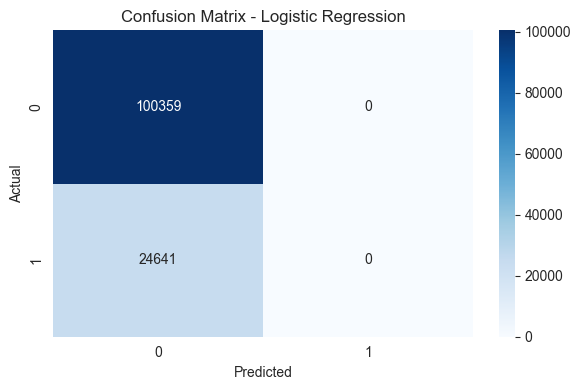

In [12]:
# Evaluation metrics
print("Logistic Regression Performance\n")

print(
    classification_report(
        y_test,
        y_pred_lr,
        zero_division=0 # When the metric is undefined, it returns 0 instead of warning
    )
)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Logistic Regression — Evaluation

The Logistic Regression model achieved an overall accuracy of approximately 80%. However, this result is misleading due to the class imbalance present in the dataset.

The confusion matrix reveals that the model classified all observations as non-delayed flights, failing to identify any delayed flights. As a result, the recall and precision
for the delayed class are both equal to zero.

This behavior highlights a known limitation of Logistic Regression in imbalanced classification problems, especially when the relationship between features and the target variable is non-linear. Although the model performs well for the majority class, it is not effective for detecting delayed flights, which is the primary objective of this task.

The Logistic Regression model was used as an interpretable baseline, and its performance was primarily evaluated through classification metrics. Feature importance analysis was explored using Random Forest, which better captures non-linear relationships. While Logistic Regression offers interpretability, Random Forest achieves better performance by capturing complex patterns.

## Model 2 — Random Forest Classifier

Random Forest was selected as a more powerful supervised model to address the limitations observed in the Logistic Regression baseline. This algorithm is capable
of capturing non-linear relationships and interactions between features, which are expected to be relevant in flight delay prediction.

In [13]:
# Random Forest pipeline
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )
        )
    ]
)

# Train Random Forest
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_pipeline.predict(X_test)

Random Forest Performance

              precision    recall  f1-score   support

           0       0.81      0.91      0.86    100359
           1       0.29      0.15      0.20     24641

    accuracy                           0.76    125000
   macro avg       0.55      0.53      0.53    125000
weighted avg       0.71      0.76      0.73    125000



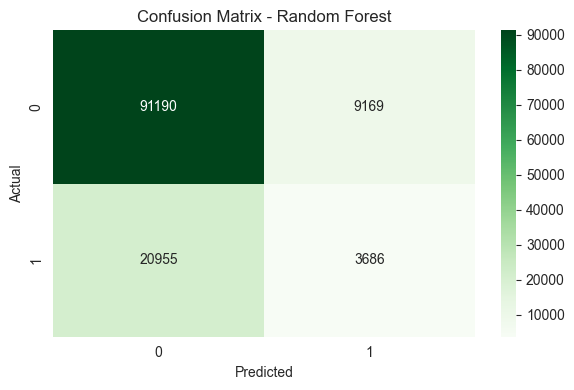

In [14]:
print("Random Forest Performance\n")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Random Forest — Evaluation

The Random Forest model demonstrated a clear improvement over Logistic Regression by capturing non-linear patterns in the data.

While overall accuracy (76%) is slightly lower than the Logistic Regression baseline, the Random Forest was able to correctly identify delayed flights, achieving a recall of 15% for the delayed class. In contrast, the Logistic Regression model failed to predict any delayed flights.

The model performs well in identifying on-time flights, with a recall of 91% for class 0. However, the relatively low recall for delayed flights highlights the inherent difficulty of predicting rare delay events using only operational and temporal features.

These results indicate that flight delays are influenced by complex factors not fully captured in the available dataset, such as weather conditions, airport congestion, and cascading delays from previous flights.

## Supervised Model Comparison

Two supervised classification models were evaluated:

- **Logistic Regression**: served as a baseline due to its simplicity and interpretability.
- **Random Forest Classifier**: used to capture non-linear relationships between features.

Logistic Regression failed to identify delayed flights, predicting only the majority class. Random Forest improved performance by detecting a subset of delayed flights, achieving better recall and F1-score for the delayed class.

Despite this improvement, both models struggled to accurately predict delays, reflecting the inherent class imbalance and the absence of key explanatory variables such as weather and airport congestion.